<a href="https://colab.research.google.com/github/Gouri-Upenn/MovieMetrics/blob/main/MovieMetrics_A_Data_Driven_Approach_to_IMDB_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages
import time
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import dask.dataframe as dd
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# The datasets we are using
!wget -q https://datasets.imdbws.com/title.basics.tsv.gz
!wget -q https://datasets.imdbws.com/title.crew.tsv.gz
!wget -q https://datasets.imdbws.com/title.episode.tsv.gz
!wget -q https://datasets.imdbws.com/title.principals.tsv.gz
!wget -q https://datasets.imdbws.com/title.ratings.tsv.gz
!wget -q https://datasets.imdbws.com/name.basics.tsv.gz

In [ ]:
!gunzip -f title.basics.tsv.gz
!gunzip -f title.crew.tsv.gz
!gunzip -f title.episode.tsv.gz
!gunzip -f title.principals.tsv.gz
!gunzip -f title.ratings.tsv.gz
!gunzip -f name.basics.tsv.gz

# **Part I: Data Wrangling, Cleaning, and Shaping**




## **1.1: loading and Preprocessing the dataframes**

We begin by loading our Datasets. We will be working with 5 datasets that are open-source datasets provided by IMDB and free to use under a non-commercial license:


*   **Movies**: This dataframe will contain information about movies such as its year, runtime, genre, title, and title identifier.
*   **Actors**: Information about the cast, which comes in the form of a mapping table from title identifier -> actor identifier
*   **Ratings**: This dataframe contains information about the ratings of a movie, and contains both the number of ratings + the average rating on a scale of 1-10.
*   **Directors**: This dataframe will contain information about the director assigned to a given movie. It comes in the form of a mapping table from title identifier -> director identifier.
*   **Names**: This is a dataframe that allows us to map people identifiers (actors, directors) to their given known names.



In [ ]:
# Actors/Actresses
IMDB_title_actors = pd.DataFrame()
for chunk in pd.read_csv('/content/title.principals.tsv', sep='\t', chunksize=1000000):
    filtered_chunk_actor = chunk[chunk['category'].isin(['actor', 'actress'])][['tconst', 'nconst']]
    IMDB_title_actors = pd.concat([IMDB_title_actors, filtered_chunk_actor])

# Movies. Note that we are explicitely filtering for titleType = movie below
# This is to avoid tv shows and series
movies_df = pd.DataFrame()
for chunk in pd.read_csv('/content/title.basics.tsv', sep='\t', chunksize=1000000):
    filtered_chunk = chunk[chunk['titleType'] == 'movie']
    movies_df = pd.concat([movies_df, filtered_chunk])

# Ratings
IMDB_title_ratings = pd.read_csv('/content/title.ratings.tsv', sep='\t')

# Directors
IMDB_directors = pd.DataFrame()
for chunk in pd.read_csv('/content/title.crew.tsv', sep='\t', chunksize=1000000):
    filtered_chunk_crew = chunk[['tconst', 'directors']]
    IMDB_directors = pd.concat([IMDB_directors, filtered_chunk_crew])

# Cast/Director Names
IMDB_name_basics = pd.read_csv('/content/name.basics.tsv', sep='\t')
IMDB_name_basics = IMDB_name_basics[['nconst', 'primaryName']]


NameError: name 'pd' is not defined

### 1.1.1: Understanding what we are working with
Let's start visualizing our datasets to understand what we are working with.

In [ ]:
movies_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama


In [ ]:
IMDB_title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2008
1,tt0000002,5.7,269
2,tt0000003,6.5,1923
3,tt0000004,5.5,178
4,tt0000005,6.2,2698


In [ ]:
IMDB_title_actors.head()

,tconst,nconst
11,tt0000005,nm0443482
12,tt0000005,nm0653042
16,tt0000007,nm0179163
17,tt0000007,nm0183947
21,tt0000008,nm0653028


In [ ]:
IMDB_directors.head()

,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690


In [ ]:
IMDB_name_basics.head()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


Above, we see that our data is mostly clean, but there are some caveats.
For example, the endYear column in our dataset is only \N. Some genres are missing, and it looks like some genres may not be right for a movie (e.g. reality TV). We will be doing a little bit of cleaning up below, before merging.

## **1.2: Cleaning and shaping**

### **1.2.1** Preprocessing the dataframe `movies_df`
Since the focus of our project is on movies, we have created a dataframe `movies_df` by selecting only the rows where `titleType` equals `movie`.

Convert datatypes of the columns of `movies_df` dataframe:

1.   `tconst` to string
2.   `titleType` to string
3.`primaryTitle` to string
4. `originalTitle` to string
5. `isAdult` to integer
6. `startYear` to integer
7. `endYear` to integer
8. `runtimeMinutes` to integer
9. `genres` to string

We will simultaniously replace the invalid character `"\N"` in `startYear,endYear and runtimeMinutes`



In [ ]:
movies_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665552 entries, 8 to 10393573
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          665552 non-null  object
 1   titleType       665552 non-null  object
 2   primaryTitle    665552 non-null  object
 3   originalTitle   665552 non-null  object
 4   isAdult         665552 non-null  object
 5   startYear       665552 non-null  object
 6   endYear         665552 non-null  object
 7   runtimeMinutes  665552 non-null  object
 8   genres          665552 non-null  object
dtypes: object(9)
memory usage: 50.8+ MB


In [ ]:
movies_df['tconst'] = movies_df['tconst'].astype('string')
movies_df['titleType'] = movies_df['titleType'].astype('string')
movies_df['primaryTitle'] = movies_df['primaryTitle'].astype('string')
movies_df['originalTitle'] = movies_df['originalTitle'].astype('string')
movies_df['isAdult'] = movies_df['isAdult'].astype('int')

movies_df['startYear'] = movies_df['startYear'].replace('\\N', 0) # replace invalid entry "\N" with 0000
movies_df['startYear'] = movies_df['startYear'].astype('int')

movies_df['runtimeMinutes'] = movies_df['runtimeMinutes'].replace('\\N', 0)
movies_df['runtimeMinutes'] = movies_df['runtimeMinutes'].astype('int')

movies_df['genres'] = movies_df['genres'].astype('string')
movies_df['genres'] = movies_df['genres'].replace('\\N', 'NULL')

movies_df = movies_df[[column for column in movies_df.columns if column != 'endYear']]

In [ ]:
movies_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,100,NULL
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama


To clean the data and eliminate invalid characters,invalid data or bad data, we will look into the unique values each column contains in the dataframe.




In [ ]:
list_of_genres = movies_df['genres'].unique().tolist()
flattened_genres = [genre for item in list_of_genres for genre in item.split(',')]
unique_genres = set(genre for genre in flattened_genres )
print(unique_genres)
print("Number of unique titleType is :" , len(movies_df['titleType'].unique()))
print("Number of unique tconst is : " , len(movies_df['tconst'].unique()))
print("Number of unique startYear is :" , len(np.sort(movies_df['startYear'].unique())))
print("Number of unique isAdult is :" , len(movies_df['isAdult'].unique()))
# print("Number of unique runtimeMinutes are : \n" , np.sort(movies_df['runtimeMinutes'].unique()),'\n')

{'Fantasy', 'News', 'Crime', 'History', 'Romance', 'Comedy', 'Musical', 'Mystery', 'Music', 'Family', 'Adventure', 'Western', 'Documentary', 'Drama', 'Talk-Show', 'Action', 'Short', 'Horror', 'Adult', 'Animation', 'Sci-Fi', 'Film-Noir', 'Game-Show', 'Thriller', 'Biography', 'Reality-TV', 'Sport', 'NULL', 'War'}
Number of unique titleType is : 1
Number of unique tconst is :  665552
Number of unique startYear is : 138
Number of unique isAdult is : 2


* From the above analysis, we see that the unique genres are :
'`Documentary', 'Horror', 'Animation','Action', 'Mystery','Sci-Fi','Crime','Romance','Thriller', 'War','Short','Game-Show','NULL','Music','Adult', 'Biography','Family','Musical','Fantasy', 'Reality-TV','Adventure','News','Drama','Western', 'History','Sport','Talk-Show','Comedy','Film-Noir'`

* We are eliminating the follwing non-movie genres from the column `genres`:
`Game-Show, NULL, Reality-TV, News, Talk-Show`

* The valid genres in our case would be:
`'Horror', 'Animation','Action', 'Mystery','Sci-Fi','Crime','Romance','Thriller', 'War','Music','Adult', 'Biography','Family','Musical','Fantasy', 'Adventure','Drama','Western', 'History','Sport', 'Comedy','Film-Noir', 'Documentary', 'Short'`

In [ ]:
excluded_genres = {'Game-Show', 'NULL', 'Reality-TV', 'News', 'Talk-Show'}

def should_exclude(genres):
    genres_set = set(genres.split(','))
    return not genres_set.difference(excluded_genres)

movies_df = movies_df[~movies_df['genres'].apply(should_exclude)]

In [ ]:
print("Number of unique tconst is after filtering for invalid genres: " , len(movies_df['tconst'].unique()))

Number of unique tconst is after filtering for invalid genres:  590687


We then keep the rows with only valid `startYear`. We will only include the movies whose `startYear` is between `1980` to `2023`



In [ ]:
movies_df = movies_df[(movies_df['startYear']>=1980) & (movies_df['startYear']<=2023)]

We can now inspect our "cleaned" DataFrame for movies.

In [ ]:
movies_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
11634,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,0,"Action,Crime"
13079,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021,94,Documentary
15482,tt0015724,movie,Dama de noche,Dama de noche,0,1993,102,"Drama,Mystery,Romance"
34798,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance"
35961,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",0,1983,118,"Drama,War"


In [ ]:
# checking for nulls or NaN for the entire dataset
num_nulls = int(movies_df.isnull().sum().sum())
print("Number of rows with null values: " , num_nulls)
nan_presence = movies_df.isna().any()
if nan_presence.any():
    print(nan_presence)
else:
    print("No NaN values found in the DataFrame.")

Number of rows with null values:  0
No NaN values found in the DataFrame.


Let's now merge the ratings data onto movies_df to get the averageRating and numVotes columns.

In [ ]:
movies_df = pd.merge(movies_df, IMDB_title_ratings[['tconst', 'numVotes', 'averageRating']], on='tconst', how='left')

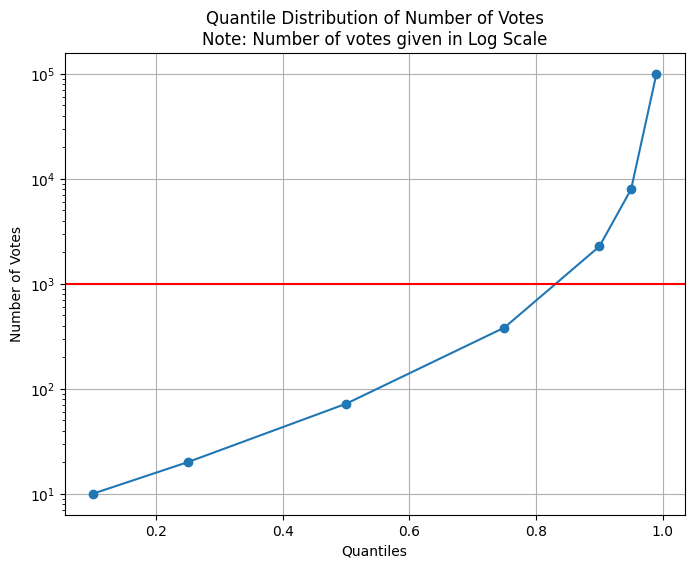

In [ ]:
quantiles = movies_df['numVotes'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

plt.figure(figsize=(8, 6))
quantiles.plot(kind='line', marker='o')
plt.title('Quantile Distribution of Number of Votes\nNote: Number of votes given in Log Scale')
plt.xlabel('Quantiles')
plt.ylabel('Number of Votes')
plt.yscale('log')
plt.axhline(y = 1000, color = 'r', linestyle = '-')
plt.grid(True)
plt.show()

We note that about 85% of Movies have less than 1000 ratings. For the purpose of this exercise, we will filter those movies out. Our reasoning for doing this is 3 fold:


1.   Practically speaking, and a rather mundane reason: our modeling will be computationally intensive given some of the features we have in mind, and this will allow us to stay manageable in size.
2.   This will allow us to filter out "Niche" titles which will only add noise to our model.
3.   This will allow us to focus our efforts on US "Block Busters", and fits well in the context of our idea of modelling used for content budgeting at large streaming companies like Netflix and Prime Video.





In [ ]:
# Creating a new dataframe as we want to persist movies_df for analysis further down
movies_df_filtered = movies_df.copy()
movies_df_filtered = movies_df_filtered[movies_df_filtered['numVotes']>=1000]

In [ ]:
movies_df_filtered.shape

(33948, 10)

### **1.2.2** Pre-Processing Cast and Directors

We see that our Movies DataFrame doesn't have much to produce a healthy model in terms of available features. We would like to add a little bit more features, for example to understand the quality of the cast and of the director.

To do this, we propose two additional features:


1.   One-Hot Encoding the presence of one of the top 20 "stars" by decade in given movies.
2.   For the top 10 actors present in the movie, what are the average ratings of movies released in the same or previous years in which they starred, EXCLUDING the current movie's rating.

We will then do the same for directors.



#### 1.2.2.1 Cast

In [ ]:
movies_actors_ratings = pd.merge(movies_df_filtered, IMDB_title_actors, on='tconst')
movies_actors_ratings['decade'] = movies_actors_ratings['startYear'] // 10 * 10
actor_votes_by_decade = movies_actors_ratings.groupby(['decade', 'nconst'])['numVotes'].sum().reset_index()
top_actors_per_decade = {}
unique_actors = set()

for decade in actor_votes_by_decade['decade'].unique():
    top_actors = actor_votes_by_decade[actor_votes_by_decade['decade'] == decade] \
                                      .sort_values(by='numVotes', ascending=False) \
                                      .head(20)
    for actor in top_actors['nconst']:
        if actor not in unique_actors:
            unique_actors.add(actor)
            top_actors_per_decade.setdefault(decade, []).append(actor)


In [ ]:
for decade in top_actors_per_decade:
    top_actors_per_decade[decade] = IMDB_name_basics[IMDB_name_basics['nconst'].isin(top_actors_per_decade[decade])]\
                                    ['primaryName'].tolist()

top_actors_per_decade

{1980: ['Dan Aykroyd',
  'Sean Connery',
  'Tom Cruise',
  'Robert De Niro',
  'Harrison Ford',
  'Michael J. Fox',
  'Jack Nicholson',
  'Michelle Pfeiffer',
  'Arnold Schwarzenegger',
  'Sylvester Stallone',
  'Sigourney Weaver',
  'Karen Allen',
  'Michael Biehn',
  'Carrie Fisher',
  'Crispin Glover',
  'Mark Hamill',
  'Christopher Lloyd',
  'Lea Thompson',
  'Shelley Duvall',
  'Billy Dee Williams'],
 1990: ['Brad Pitt',
  'Jim Carrey',
  'Morgan Freeman',
  'Tom Hanks',
  'Anthony Hopkins',
  'Samuel L. Jackson',
  'Al Pacino',
  'Keanu Reeves',
  'Tim Robbins',
  'Kevin Spacey',
  'Uma Thurman',
  'John Travolta',
  'Robin Williams',
  'Bruce Willis',
  'Matt Damon',
  'Joe Pesci',
  'Edward Norton',
  'William Sadler',
  'Bob Gunton'],
 2000: ['George Clooney',
  'Russell Crowe',
  'Johnny Depp',
  'Leonardo DiCaprio',
  'Ewan McGregor',
  'Will Smith',
  'Christian Bale',
  'Michael Caine',
  'Elijah Wood',
  'Viggo Mortensen',
  'Heath Ledger',
  'Ian McKellen',
  'Orlando B

Looking at the actor names from the 80s and 90s offers a good stab of nostalgia, doesn't it?

Some observations: Though the top actors match our intuition of the big names of each decade, it certainly seems to skew towards US/Hollywood actors, which means that non-US films may not be as well modeled in our data. We think this is a necessary compromise, since one hot encoding all actors would result in an enormously fat dataset which would be very difficult to process computationally. The second observation is that we can infer the presence of movies in the list that are skewing the counts. For example, Mark Hamill, Carrie Fisher, and Harrison Ford are marked as top actors from the 80s, because Star Wars was a cult classic that has received many many reviews. In the future, we may want to winsorize the data to prevent outlier movies from affecting the one hot encoding too much.

Now that we have our top actors, we one hot encode the list into our movies Dataset. Note, this operation takes a while to run (about 3 min).

In [ ]:
for actor in unique_actors:
    movies_df_filtered[actor] = movies_df_filtered['tconst'].isin(IMDB_title_actors[IMDB_title_actors['nconst'] == actor]['tconst'])

In [ ]:
movies_df_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,numVotes,averageRating,...,nm0000417,nm0000299,nm0000199,nm0000288,nm0000402,nm0268199,nm0001570,nm0705356,nm0000209,nm0000354
3,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",88131.0,6.4,...,False,False,False,False,False,False,False,False,False,False
6,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980,58,"Documentary,War",1986.0,7.4,...,False,False,False,False,False,False,False,False,False,False
20,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986,96,"Drama,War",2526.0,7.9,...,False,False,False,False,False,False,False,False,False,False
26,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama,7899.0,6.7,...,False,False,False,False,False,False,False,False,False,False
46,tt0075788,movie,"Bruce Lee, the Legend",Bruce Lee: The Legend,0,1984,88,Documentary,1222.0,7.1,...,False,False,False,False,False,False,False,False,False,False


Now that we have our one hot encoded version of cast, let's build some measure of "quality of cast" into our dataset. To do this, we will produce an average "quality" of cast, by averaging out all the ratings of all the movies each cast member was in, adjusting for the current movie. For example, if Leonardo DiCaprio's ratings (excluding the movie "Titanic") is x, then Leonardo DiCaprio will contribute x towards the "cast quality" of the movie Titanic. We average this out to normalize, since not every movie will have the same amount of associated actors (see below for distribution).

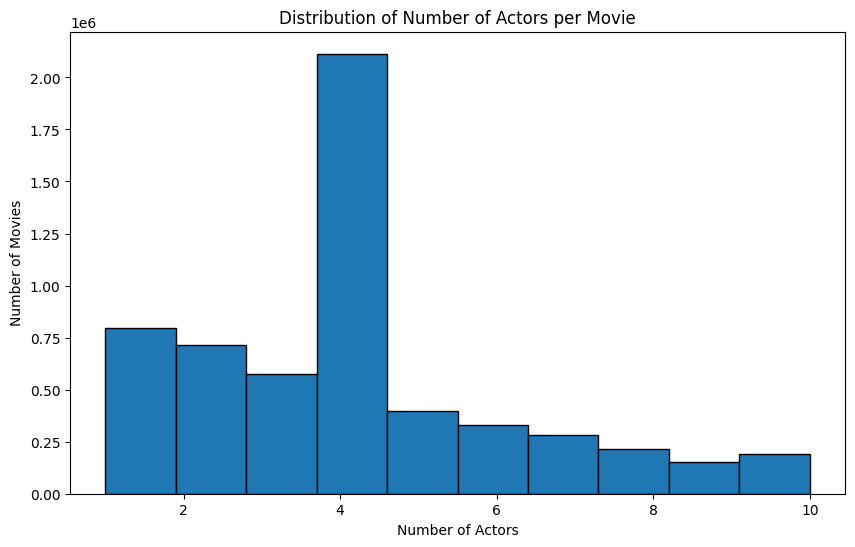

In [ ]:
actors_per_movie = IMDB_title_actors.groupby('tconst').size()

plt.figure(figsize=(10, 6))
actors_per_movie.plot(kind='hist', edgecolor='black')
plt.title('Distribution of Number of Actors per Movie')
plt.xlabel('Number of Actors')
plt.ylabel('Number of Movies')
plt.show()


In [ ]:
movies_actors_ratings = pd.merge(movies_df_filtered, IMDB_title_actors, on='tconst')

actor_rating_summary = movies_actors_ratings.groupby('nconst').agg({
    'averageRating': 'sum',
    'tconst': 'count'
}).reset_index()
actor_rating_summary.rename(columns={'averageRating': 'sumOfRatings', 'tconst': 'numberOfMovies'}, inplace=True)
actor_rating_summary = actor_rating_summary[actor_rating_summary['numberOfMovies']>1]
actor_rating_summary.head()


,nconst,sumOfRatings,numberOfMovies
1,nm0000002,57.0,10
2,nm0000004,19.6,3
3,nm0000008,53.2,9
6,nm0000012,17.1,3
7,nm0000018,48.0,8


In [ ]:
merged_df = pd.merge(movies_df, IMDB_title_actors, on='tconst')
merged_df = pd.merge(merged_df, actor_rating_summary, on='nconst')

merged_df = merged_df[['tconst', 'nconst', 'sumOfRatings', 'numberOfMovies', 'averageRating', 'numVotes']]

merged_df.head()


,tconst,nconst,sumOfRatings,numberOfMovies,averageRating,numVotes
0,tt0035423,nm0000212,188.3,31,6.4,88131.0
1,tt0090660,nm0000212,188.3,31,5.7,12527.0
2,tt0093260,nm0000212,188.3,31,6.8,64108.0
3,tt0094933,nm0000212,188.3,31,6.1,10820.0
4,tt0095897,nm0000212,188.3,31,5.9,19755.0


In [ ]:
merged_df['movieAdjustedActorRating'] = (merged_df['sumOfRatings'] - merged_df['averageRating']) / (merged_df['numberOfMovies'] - 1)

In [ ]:
merged_df.head()

,tconst,nconst,sumOfRatings,numberOfMovies,averageRating,numVotes,movieAdjustedActorRating
0,tt0035423,nm0000212,188.3,31,6.4,88131.0,6.063333
1,tt0090660,nm0000212,188.3,31,5.7,12527.0,6.086667
2,tt0093260,nm0000212,188.3,31,6.8,64108.0,6.050000
3,tt0094933,nm0000212,188.3,31,6.1,10820.0,6.073333
4,tt0095897,nm0000212,188.3,31,5.9,19755.0,6.080000


In [ ]:
average_ratings = merged_df.groupby('tconst')['movieAdjustedActorRating'].mean().reset_index()

movies_df_filtered = pd.merge(movies_df_filtered, average_ratings, on='tconst', how='left')

movies_df_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,numVotes,averageRating,...,nm0000299,nm0000199,nm0000288,nm0000402,nm0268199,nm0001570,nm0705356,nm0000209,nm0000354,movieAdjustedActorRating
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",88131.0,6.4,...,False,False,False,False,False,False,False,False,False,6.233725
1,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980,58,"Documentary,War",1986.0,7.4,...,False,False,False,False,False,False,False,False,False,NaN
2,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986,96,"Drama,War",2526.0,7.9,...,False,False,False,False,False,False,False,False,False,7.300000
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama,7899.0,6.7,...,False,False,False,False,False,False,False,False,False,6.250000
4,tt0075788,movie,"Bruce Lee, the Legend",Bruce Lee: The Legend,0,1984,88,Documentary,1222.0,7.1,...,False,False,False,False,False,False,False,False,False,NaN


#### 1.2.2.2 Directors

Below, we perform the same operations for Directors as we did above for Actors. This should be simpler, as presumably the number of Directors per movie will be smaller.

In [ ]:
movies_directors_ratings = pd.merge(movies_df_filtered, IMDB_directors, on='tconst')

movies_directors_ratings['decade'] = movies_directors_ratings['startYear'] // 10 * 10
directors_votes_by_decade = movies_directors_ratings.groupby(['decade', 'directors'])['numVotes'].sum().reset_index()

top_directors_per_decade = {}
unique_directors = set()

for decade in directors_votes_by_decade['decade'].unique():
    top_directors = directors_votes_by_decade[directors_votes_by_decade['decade'] == decade] \
                                      .sort_values(by='numVotes', ascending=False) \
                                      .head(20)
    for director in top_directors['directors']:
        if director not in unique_directors:
            unique_directors.add(director)
            top_directors_per_decade.setdefault(decade, []).append(director)


In [ ]:
for decade in top_directors_per_decade:
    top_directors_per_decade[decade] = IMDB_name_basics[IMDB_name_basics['nconst'].isin(top_directors_per_decade[decade])]\
                                    ['primaryName'].tolist()

top_directors_per_decade

{1980: ['Stanley Kubrick',
  'James Cameron',
  'John Carpenter',
  'Steven Spielberg',
  'Oliver Stone',
  'Tim Burton',
  'Brian De Palma',
  'John Hughes',
  'John Landis',
  'Ridley Scott',
  'Robert Zemeckis',
  'Richard Donner',
  'Barry Levinson',
  'John McTiernan',
  'Rob Reiner',
  'Peter Weir',
  'Irvin Kershner',
  'Richard Marquand',
  'Hayao Miyazaki',
  'Ivan Reitman'],
 1990: ['Luc Besson',
  'Martin Scorsese',
  'Quentin Tarantino',
  'David Fincher',
  'Chris Columbus',
  'Frank Darabont',
  'Jonathan Demme',
  'Joel Schumacher',
  'Bryan Singer',
  'Barry Sonnenfeld',
  'Gus Van Sant',
  'Sam Mendes',
  'Tony Kaye'],
 2000: ['Clint Eastwood',
  'Ron Howard',
  'George Lucas',
  'Sam Raimi',
  'Michael Bay',
  'Peter Jackson',
  'Steven Soderbergh',
  'Guy Ritchie',
  'Christopher Nolan',
  'Zack Snyder',
  'Guillermo del Toro',
  'Gore Verbinski'],
 2010: ['James Mangold',
  'J.J. Abrams',
  'James Gunn',
  'Rian Johnson',
  'Todd Phillips',
  'Matthew Vaughn',
  'De

In [ ]:
# Our code produces some futureWarnings that we want to hide for a cleaner output.
# The warnings do not impact the functionality of what follows.
import warnings
warnings.filterwarnings('ignore')
for director in unique_directors:
    movies_df_filtered[director] = movies_df_filtered['tconst'].isin(IMDB_directors[IMDB_directors['directors'] == director]['tconst'])

In [ ]:
movies_directors_ratings = pd.merge(movies_df, IMDB_directors, on='tconst')

director_rating_summary = movies_directors_ratings.groupby('directors').agg({
    'averageRating': 'sum',
    'tconst': 'count'
}).reset_index()
director_rating_summary.rename(columns={'averageRating': 'sumOfRatings', 'tconst': 'numberOfMovies'}, inplace=True)
director_rating_summary = director_rating_summary[director_rating_summary['numberOfMovies']>1]
director_rating_summary.head()


,directors,sumOfRatings,numberOfMovies
0,\N,14937.2,12850
1,nm0000005,23.2,3
2,nm0000019,34.9,5
4,nm0000040,24.2,3
5,nm0000041,23.3,3


In [ ]:
merged_df = pd.merge(movies_df, IMDB_directors, on='tconst')
merged_df = pd.merge(merged_df, director_rating_summary, on='directors')

merged_df = merged_df[['tconst', 'directors', 'sumOfRatings', 'numberOfMovies', 'averageRating', 'numVotes']]

merged_df.head()


,tconst,directors,sumOfRatings,numberOfMovies,averageRating,numVotes
0,tt0015724,nm0529960,18.1,3,6.1,27.0
1,tt0314085,nm0529960,18.1,3,5.8,122.0
2,tt1139666,nm0529960,18.1,3,6.2,246.0
3,tt0035423,nm0003506,86.0,12,6.4,88131.0
4,tt0113280,nm0003506,86.0,12,6.7,5785.0


In [ ]:
merged_df['movieAdjustedDirectorRating'] = (merged_df['sumOfRatings'] - merged_df['averageRating']) / (merged_df['numberOfMovies'] - 1)

average_ratings = merged_df.groupby('tconst')['movieAdjustedDirectorRating'].mean().reset_index()

movies_df_filtered = pd.merge(movies_df_filtered, average_ratings, on='tconst', how='left')

movies_df_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,numVotes,averageRating,...,nm0000229,nm0005363,nm0001837,nm0009190,nm1560977,nm1429471,nm0570912,nm0000040,nm0811583,movieAdjustedDirectorRating
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance",88131.0,6.4,...,False,False,False,False,False,False,False,False,False,7.236364
1,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980,58,"Documentary,War",1986.0,7.4,...,False,False,False,False,False,False,False,False,False,6.366667
2,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986,96,"Drama,War",2526.0,7.9,...,False,False,False,False,False,False,False,False,False,7.133333
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama,7899.0,6.7,...,False,False,False,False,False,False,False,False,False,5.150000
4,tt0075788,movie,"Bruce Lee, the Legend",Bruce Lee: The Legend,0,1984,88,Documentary,1222.0,7.1,...,False,False,False,False,False,False,False,False,False,NaN


Now that we ave our actor/director-encoded Dataframe, let's encode the True/False Boolean values that we see appear in the one hot encoded actors and directors columns as 0 and 1s.

In [ ]:
movies_df_filtered = movies_df_filtered*1

We still have some work to do. Namely - we can clean up the dataset by removing string columns that don't carry any value, as well as one-hot-encode the genre of the film.

### 1.2.3 Pre-Processing Genre

In this section, we will transform categorical genre information for the modelling task, enhancing the dataset with a more structured representation of movie genres. We will do so by first splitting the genres into lists and then one-hot encodes them, creating a binary matrix. After merging this matrix with the original DataFrame, redundant columns are dropped.

A note regarding the genre list: In cases where a movie is labeled as 'Horror/Reality-TV,' although 'Reality-TV' is considered invalid, 'Horror' is valid. Therefore, we opt to retain the movie rather than removing it. Consequently, 'Reality-TV' may still be present in the one-hot-encoded vector. We have chosen to keep genres that are not in the 'valid' list mentioned in the earlier section. The rationale behind this decision is that, in the worst-case scenario, it adds no value, while in the best case, it might contribute to a slight improvement in performance.

In [ ]:
movies_df_filtered['genres_list'] = movies_df_filtered['genres'].str.split(',')

one_hot_encoded_genres = movies_df_filtered['genres_list'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

movies_df_filtered = pd.concat([movies_df_filtered, one_hot_encoded_genres], axis=1)

movies_df_filtered = movies_df_filtered.drop(['genres', 'genres_list'], axis=1)

movies_df_filtered.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,numVotes,averageRating,nm0413168,...,History,Adult,Music,Biography,Thriller,Musical,Sport,Western,News,Reality-TV
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,88131.0,6.4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980,58,1986.0,7.4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986,96,2526.0,7.9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,7899.0,6.7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0075788,movie,"Bruce Lee, the Legend",Bruce Lee: The Legend,0,1984,88,1222.0,7.1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
genres = ['Comedy', 'Fantasy', 'Romance', 'Documentary', 'War', 'Drama', 'Adventure', 'Action', 'Crime', 'Mystery', 'Horror', 'Sci-Fi', 'Animation', 'Family', 'History', 'Adult', 'Music', 'Biography', 'Thriller', 'Musical', 'Sport', 'Western', 'News', 'Reality-TV']

In [ ]:
movies_df_filtered['num_genres'] = sum(movies_df_filtered[column] for column in genres)

In [ ]:
movies_df_filtered

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,numVotes,averageRating,nm0413168,...,Adult,Music,Biography,Thriller,Musical,Sport,Western,News,Reality-TV,num_genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,88131.0,6.4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,tt0038687,movie,Let There Be Light,Let There Be Light,0,1980,58,1986.0,7.4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,tt0067625,movie,Trial on the Road,Proverka na dorogakh,0,1986,96,2526.0,7.9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,7899.0,6.7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,tt0075788,movie,"Bruce Lee, the Legend",Bruce Lee: The Legend,0,1984,88,1222.0,7.1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33943,tt9907782,movie,The Cursed,Eight for Silver,0,2021,111,14980.0,6.2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
33944,tt9908390,movie,Le lion,Le lion,0,2020,95,1353.0,5.5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33945,tt9911196,movie,The Marriage Escape,De beentjes van Sint-Hildegard,0,2020,103,3202.0,7.5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
33946,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,84,1453.0,5.8,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


The final step is to remove the columns we do not need for modeling (e.g. titleType, primatyTitle, etc). We also remap the column names to show the actual name of the cast member / director, instead of their identifier.


In [ ]:
names_dict = dict(zip(IMDB_name_basics.nconst, IMDB_name_basics.primaryName))

In [ ]:
columns_to_remove = ['titleType', 'primaryTitle', 'originalTitle']
final_df = movies_df_filtered[[column for column in movies_df_filtered.columns if column not in columns_to_remove]]
columns = []
for column in final_df.columns:
  if column[:2]=='nm':
    columns.append(names_dict.get(column, column))
  else:
    columns.append(column)

In [ ]:
final_df.columns=columns

In [ ]:
final_df

,tconst,isAdult,startYear,runtimeMinutes,numVotes,averageRating,Hugh Jackman,Anne Hathaway,Elijah Wood,Russell Crowe,...,Adult,Music,Biography,Thriller,Musical,Sport,Western,News,Reality-TV,num_genres
0,tt0035423,0,2001,118,88131.0,6.4,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,tt0038687,0,1980,58,1986.0,7.4,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,tt0067625,0,1986,96,2526.0,7.9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,tt0069049,0,2018,122,7899.0,6.7,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,tt0075788,0,1984,88,1222.0,7.1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33943,tt9907782,0,2021,111,14980.0,6.2,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
33944,tt9908390,0,2020,95,1353.0,5.5,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33945,tt9911196,0,2020,103,3202.0,7.5,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
33946,tt9916270,0,2020,84,1453.0,5.8,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## 1.3: Discussing potential risks and issues with our model based on Exploratory Data Analysis (EDA)

The EDA section covers undersampling for class distribution balance, examines genre distributions for insights into movie diversity, and explores correlation plots revealing relationships between key variables. The insights in this section lay the groundwork for subsequent modeling and enhance the overall robustness of our modelling approach.

### 1.3.1 Challenge with undersampling

For computational efficiency, we chose to undersample our dataset by removing movies with less than 1000 ratings. This is risky, because the resulting dataset could end up not being representative of the movie population in our original dataset. To see this, let's start plotting.

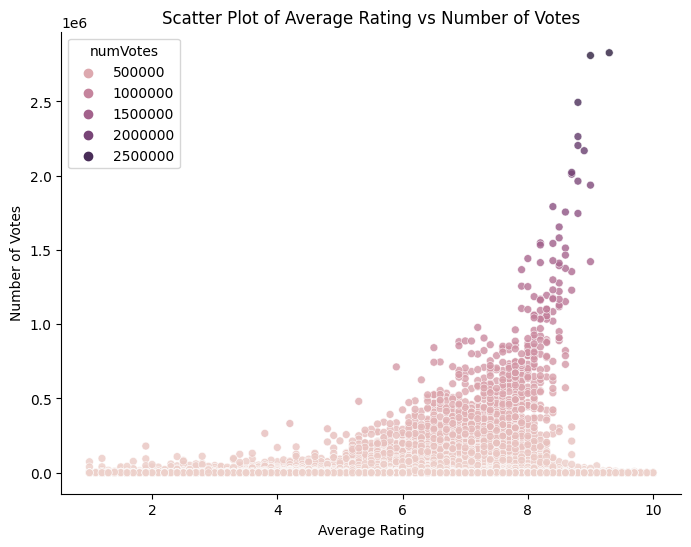

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=movies_df, x='averageRating', y='numVotes', hue='numVotes', s=32, alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Scatter Plot of Average Rating vs Number of Votes")
plt.xlabel("Average Rating")
plt.ylabel("Number of Votes")
plt.show()

The scatter plot depicts a positive correlation between average rating and the number of votes. There are a few outliers with exceptionally high votes, most of which correspond to ratings of 8 and above, suggesting highly acclaimed and popular movies in the dataset.

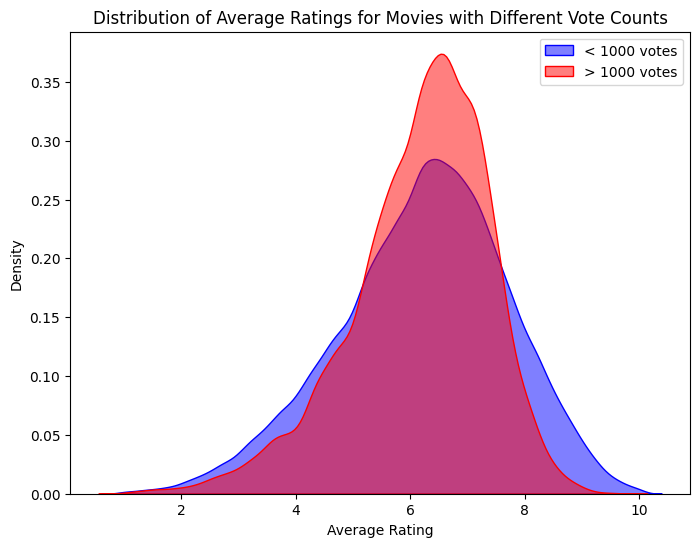

In [ ]:
less_than_1000_votes = movies_df[movies_df['numVotes'] < 1000]['averageRating']
more_than_1000_votes = movies_df[movies_df['numVotes'] > 1000]['averageRating']

plt.figure(figsize=(8, 6))
sns.kdeplot(less_than_1000_votes, color="blue", shade=True, alpha=0.5, label="< 1000 votes")
sns.kdeplot(more_than_1000_votes, color="red", shade=True, alpha=0.5, label="> 1000 votes")
plt.title('Distribution of Average Ratings for Movies with Different Vote Counts')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

The plot above is reassuring, it means that our means are roughly in the same ballpark, although the model will be expected to have slightly less variance for > 1000 vote movies than < 1000 vote movies, based on the "fatness" of the distributions above. Therefore, reducing the dataset to >1000 reviews should not induce any bias in our modeling, which would be the main concern for such an operation.

### 1.3.2 Genre Distributions

Next, we want to examine the distribution of genres. Our model may offer better modeling for highly represented genres than for niche genres in our dataset. We also want to see if there are outliers or unexpected distributions in the dataset. To achieve this, we will plot the count of each genre and average rating by genre.

In [ ]:
genres_df = movies_df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
movies_genres_df = movies_df.drop('genres', axis=1).merge(genres_df, left_index=True, right_index=True)

#Exclude the invalid genres from the plot
genres_to_exclude = ['Game-Show', 'NULL', 'Reality-TV', 'News', 'Talk-Show']
movies_genres_df = movies_genres_df[~movies_genres_df['genre'].isin(genres_to_exclude)]

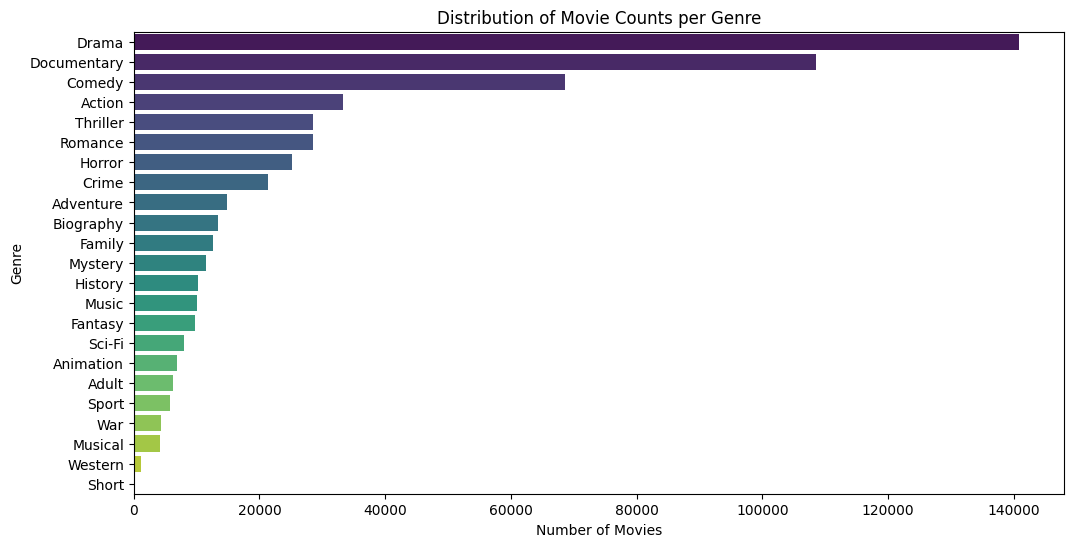

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='genre', data=movies_genres_df, order=movies_genres_df['genre'].value_counts().index, palette='viridis')
plt.title('Distribution of Movie Counts per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

Note that a movie can belong to more than one genre. Our modeling may exhibit greater accuracy for extensively represented genres like Drama, Documentary, and Comedy, as opposed to relatively specialized genres such as War, Musical, and Western.

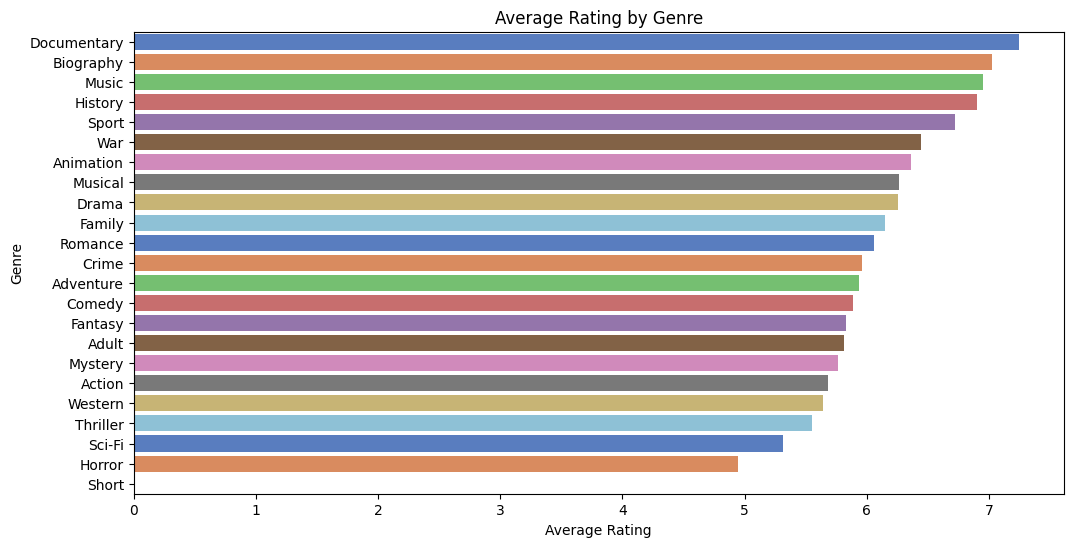

In [ ]:
average_rating_by_genre = movies_genres_df.groupby('genre')['averageRating'].mean().reset_index()
average_rating_by_genre = average_rating_by_genre.sort_values(by='averageRating', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='averageRating', y='genre', data=average_rating_by_genre, ci=None, palette='muted')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

While genres like Documentary and Biography tend to have higher average ratings compared to others like Sci-fi and Horror, there is no distinct outlier in the average rating distribution.

### 1.3.3 Correlation plots

Below, we use correlation plots to explore relationships in the multivariate dataset and identify potential patterns. Mainly, we want to know the relationship between the target variables, 'averageRating' and 'numVotes', and the other variables in the dataset.

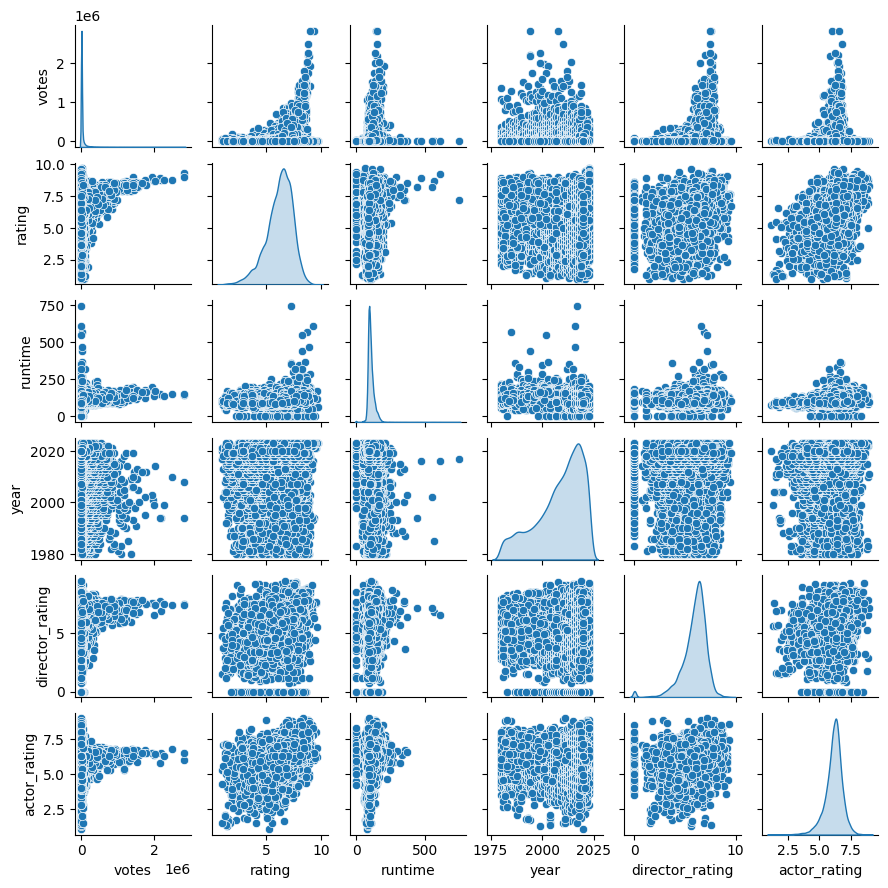

In [ ]:
num_columns = ['numVotes', 'averageRating', 'runtimeMinutes', 'startYear',
               'movieAdjustedDirectorRating', 'movieAdjustedActorRating']

num_df = final_df[num_columns]
# renaming the columns for the sake of legibility in the pairplot below.
num_df.columns = ['votes', 'rating', 'runtime', 'year', 'director_rating', 'actor_rating']

sns.pairplot(num_df, diag_kind="kde", height=1.5)

From the correlation plots, we have observed that 'rating' and 'votes' are positively correlated; that is, the more votes a title receives, the higher its average rating, and vice versa. Generally, there are no obvious outliers in the variables, except for some outliers in the variable 'runtime.' 'Runtime' is highly correlated with votes but not as much with rating. 'Actor_rating' and 'director_rating' are highly correlated with the target variable 'votes' but not as much with the target variable 'rating.'

## 1.4 Modeling IMDB Ratings

Now that we have a dataframe that is in a shape we can use, let's start modeling. We choose to model both Ratings and Votes. While our primary target is Ratings, we were curious how our model would fare at predicting votes. Note that for the below, we investigate dimensionality reduction and pass both the reduced $X$ to our model, as well as the base $X$ (without PCA). We also run a plethora of regression models with different hyperparameters etc. The hyperparameter tuning took a long time to run (90 minutes), so we did this offline first and then narrowed the hyperparameters in our param grid below to only take into account the best parameters for our models.

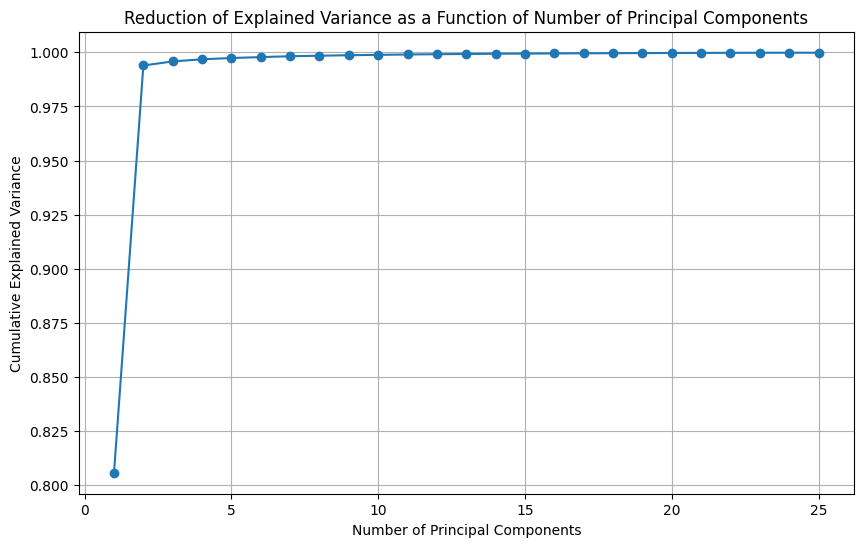

In [ ]:
target1 = 'averageRating'
target2 = 'numVotes'

y1, y2 = final_df[target1], final_df[target2]
X = final_df[[column for column in final_df.columns if column not in [target1, target2, 'tconst']]]
X.fillna(value=X.mean(), inplace=True)

# Normalizing X in preparation for modeling
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

pca = PCA(n_components=25).fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
n_components = range(1, len(cumulative_explained_variance) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_components, cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Reduction of Explained Variance as a Function of Number of Principal Components')
plt.grid(True)
plt.show()

X_pca = pd.DataFrame(pca.transform(X))


We can see from the plot above that the majority of the variance in our dataset can be explained by a few principal components. This is good, as it means we can drastically improve the training performance of our model. However, it also means that a lot of the features in our dataset are not helpful, most likely because the majority of the features in our dataset are one hot encoded features which results in very sparse data.

In the cell below, we run a plethora of regression models on a combination of different datasets. We have 4 possible combinations of data we are working with:


*   PCA Transformed X + Rating Target
*   Normal X + Rating Target
*   PCA Transformed X + Votes Target
*   Normal X + Votes Target

For each combination, we fit 5 different regression models using Cross Validation with 5 folds and a set of hyperparameters that are defined inside of a hyperparameter grid. We will collect all of the performance metrics for the models and report below. Note that we use a variety of different performance metrics including RMSE, MSE, and R^2.



In [ ]:
model_types = {
    "PCA_Rating": [X_pca, y1],
    "Normal_Rating": [X, y1],
    "PCA_Votes": [X_pca, y2],
    "Normal_Votes": [X, y2]
}

# The code below fits on X_train and transforms X_test based on fit.
# This applies to both PCA (optional) and standardscaler (mandatory)
def train_test_split_pca(X, y, n_components=None):
  scaler = StandardScaler()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  if n_components:
    pca = PCA(n_components=25)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, y_train, y_test
  return X_train, X_test, y_train, y_test

for name, data in model_types.items():
  if name[:3]=="PCA":
    data.extend(train_test_split_pca(data[0], data[1], n_components=25))
  else:
    data.extend(train_test_split_pca(data[0], data[1]))

**WARNING: The cell below can take up to 90 minutes to run with multiple model parameters to run.**

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(),
    # 'SVR': SVR(),
    'XGBRegressor': XGBRegressor()
}

param_grids = {
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'RandomForestRegressor': {'n_estimators': [200]},
    'SVR': {'C': [0.1], 'gamma': [0.01]},
    'XGBRegressor': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.05]
    }
}

def train_and_evaluate_with_hyperparams(X_train,
                                        y_train,
                                        X_test,
                                        y_test,
                                        models,
                                        param_grids,
                                        model_type="Base"):
    results = {}
    for name, model in models.items():
        start_time = time.time()
        print(f"Fitting {name} model.")
        if name in param_grids:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model.fit(X_train, y_train)
            best_params = None

        # Predictions and evaluation
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[model_type+'_'+name] = {
            'RMSE': rmse,
            'MSE': mse,
            'R2': r2,
            'Best Parameters': best_params,
            'Fit time': (time.time() - start_time)
        }
        print(f"Best {model_type+'_'+name} model results: {results[model_type+'_'+name]}")
        print("----------------------------------------\n")

    return results

results = []

for model_type, datasets in model_types.items():
  results.append(train_and_evaluate_with_hyperparams(datasets[2], datasets[4], datasets[3], datasets[5], models, param_grids, model_type=model_type))

Fitting LinearRegression model.
Best PCA_Rating_LinearRegression model results: {'RMSE': 0.8838938600648599, 'MSE': 0.7812683558603583, 'R2': 0.45122356463626534, 'Best Parameters': None, 'Fit time': 0.049735307693481445}
----------------------------------------

Fitting Ridge model.
Best PCA_Rating_Ridge model results: {'RMSE': 0.8839185697488657, 'MSE': 0.7813120379468804, 'R2': 0.4511928815815235, 'Best Parameters': {'alpha': 10}, 'Fit time': 0.6383323669433594}
----------------------------------------

Fitting Lasso model.
Best PCA_Rating_Lasso model results: {'RMSE': 0.8838119724395388, 'MSE': 0.781123602627468, 'R2': 0.45132524181614464, 'Best Parameters': {'alpha': 0.001}, 'Fit time': 1.2021770477294922}
----------------------------------------

Fitting RandomForestRegressor model.
Best PCA_Rating_RandomForestRegressor model results: {'RMSE': 0.8699440444870138, 'MSE': 0.7568026405384235, 'R2': 0.4684087071577615, 'Best Parameters': {'n_estimators': 200}, 'Fit time': 1270.394860

In [ ]:
results_df = pd.concat([pd.DataFrame.from_dict(result, orient='index') for result in results])

In [ ]:
results_df = pd.concat([pd.DataFrame.from_dict(result, orient='index') for result in results])

NameError: name 'pd' is not defined

In [ ]:
# Given how long the cell above takes to run, I am persisting results_df
# So that we don't have to rerun the modeling every time.
# Uncomment the below to do the same.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# WRITE
#results_df.to_csv('/content/drive/MyDrive/results_df.csv')

# READ
results_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/results_df.csv')
results_df = results_df[[column for column in results_df.columns if column != 'index']]
results_df = results_df.rename(columns={'Unnamed: 0': 'index'})

In [ ]:
results_df = results_df.reset_index()
# Splitting index into distinct columns for data type, target, and model
results_df[['datatype', 'target', 'model']] = results_df['index'].str.split('_', expand=True)
results_df = results_df[[column for column in results_df.columns if column != 'level_0']]

Now that we have successfully trained our models, let's show the performance and benchmarks, first in table format, and then as a couple of plots. We will comment on those further below.

In [ ]:
results_df

,index,RMSE,MSE,R2,Best Parameters,Fit time,datatype,target,model
0,PCA_Rating_LinearRegression,0.883894,7.812684e-01,0.451224,NaN,0.049735,PCA,Rating,LinearRegression
1,PCA_Rating_Ridge,0.883919,7.813120e-01,0.451193,{'alpha': 10},0.638332,PCA,Rating,Ridge
2,PCA_Rating_Lasso,0.883812,7.811236e-01,0.451325,{'alpha': 0.001},1.202177,PCA,Rating,Lasso
3,PCA_Rating_RandomForestRegressor,0.869944,7.568026e-01,0.468409,{'n_estimators': 200},1270.394861,PCA,Rating,RandomForestRegressor
4,PCA_Rating_XGBRegressor,0.850236,7.229008e-01,0.492222,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",47.200006,PCA,Rating,XGBRegressor
5,Normal_Rating_LinearRegression,0.882467,7.787485e-01,0.452994,NaN,0.853885,Normal,Rating,LinearRegression
6,Normal_Rating_Ridge,0.881786,7.775459e-01,0.453838,{'alpha': 10},4.715955,Normal,Rating,Ridge
7,Normal_Rating_Lasso,0.883771,7.810517e-01,0.451376,{'alpha': 0.001},5.786105,Normal,Rating,Lasso
8,Normal_Rating_RandomForestRegressor,0.871377,7.592974e-01,0.466656,{'n_estimators': 200},501.391636,Normal,Rating,RandomForestRegressor
9,Normal_Rating_XGBRegressor,0.845656,7.151336e-01,0.497678,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",75.423030,Normal,Rating,XGBRegressor


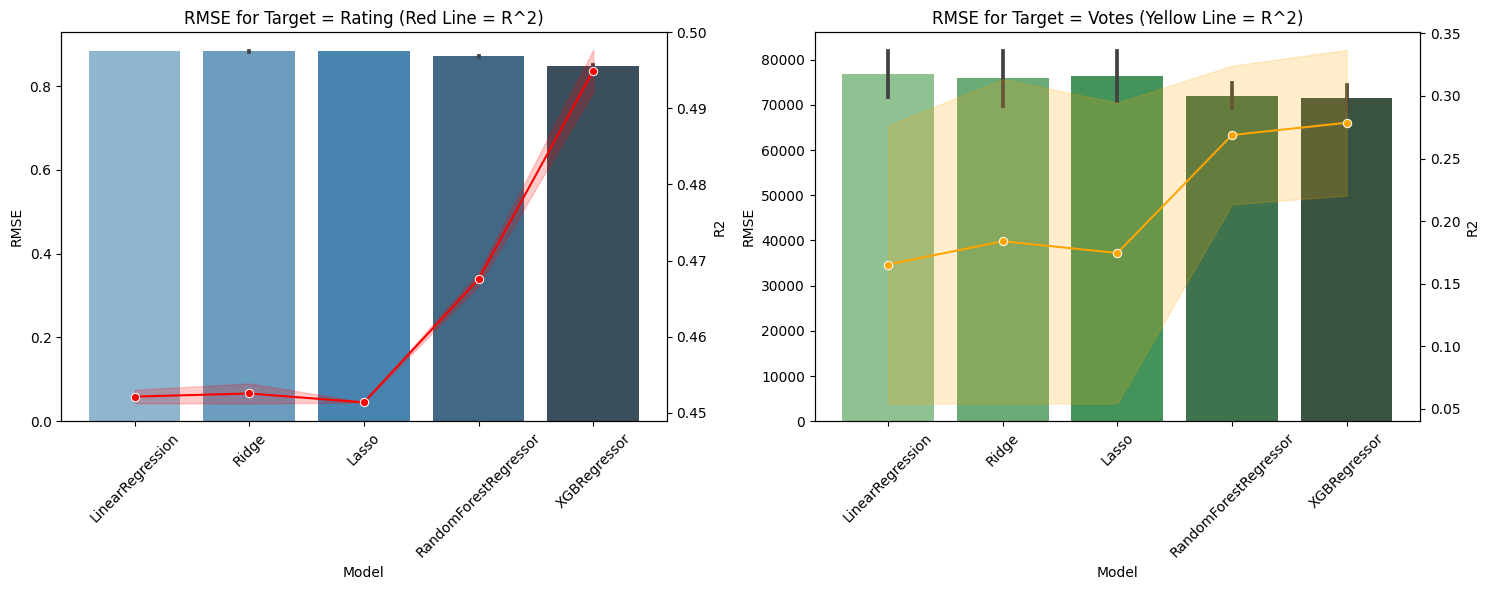

In [ ]:
rating_df = results_df[results_df['target'] == 'Rating']
votes_df = results_df[results_df['target'] == 'Votes']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ratings
sns.barplot(ax=axes[0], x='model', y='RMSE', data=rating_df, palette='Blues_d')
axes[0].set_title('RMSE for Target = Rating (Red Line = R^2)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes0_2 = axes[0].twinx()
sns.lineplot(ax=axes0_2, x='model', y='R2', data=rating_df, color='red', marker='o')
axes0_2.set_ylabel('R2')

# Votes
sns.barplot(ax=axes[1], x='model', y='RMSE', data=votes_df, palette='Greens_d')
axes[1].set_title('RMSE for Target = Votes (Yellow Line = R^2)')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes1_2 = axes[1].twinx()
sns.lineplot(ax=axes1_2, x='model', y='R2', data=votes_df, color='orange', marker='o')
axes1_2.set_ylabel('R2')

plt.tight_layout()
plt.show()


We can see above that our XGBRegressor performs the best across both targets (average rating and number of votes). In general, it is hard to say whether these results are good - the average RMSE is about .88, which is on a scale of 10, so that doesn't sound too bad, however the RMSE for votes is very high, and I probably wouldn't trust this model at all.

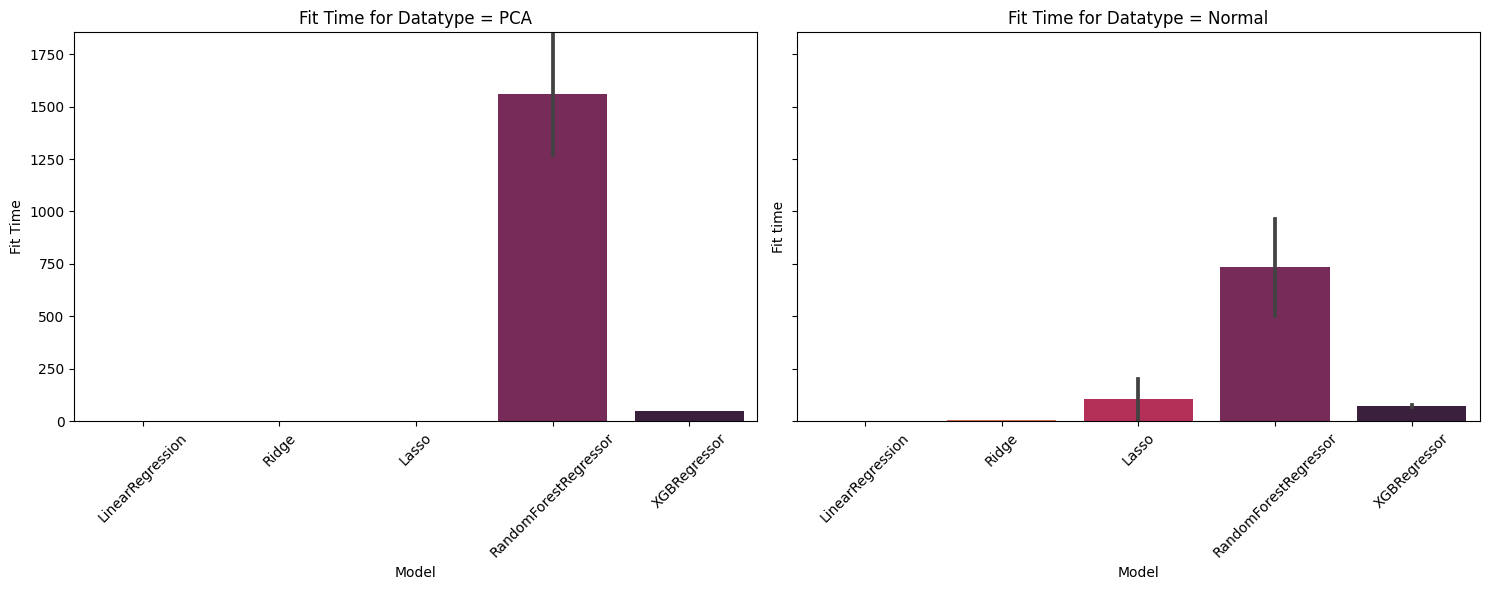

In [ ]:
pca_df = results_df[results_df['datatype'] == 'PCA']
normal_df = results_df[results_df['datatype'] == 'Normal']
max_fit_time = results_df['Fit time'].max()
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# PCA Dataset
sns.barplot(ax=axes[0], x='model', y='Fit time', data=pca_df, palette='rocket_r')
axes[0].set_title('Fit Time for Datatype = PCA')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Fit Time')
axes[0].set_ylim(0, max_fit_time)
axes[0].tick_params(axis='x', rotation=45)

# Normal Dataset (non PCA'd)
sns.barplot(ax=axes[1], x='model', y='Fit time', data=normal_df, palette='rocket_r')
axes[1].set_title('Fit Time for Datatype = Normal')
axes[1].set_xlabel('Model')
axes[1].set_ylim(0, max_fit_time)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

An interesting side note is that while PCA has improved fit times overall, the one very notable exception is RandomForest Regressor, which took muh longer to train on the PCA transformed dataset. Our hypothesis is that RandomForest's computational complexity is O(m*u), where m is the number of columns and u is the number of unique values per column. While m is much smaller for PCA, u is much larger due to PCA creating dense features instead of the 0 and 1 values we had for most of the features in our original dataset.